# Symmetric Funnel Decomposition Analysis - Demo

This notebook demonstrates the **symmetric (order-independent)** funnel decomposition analysis workflow.

## Key Difference from Hierarchical Approach

**Hierarchical decomposition** uses a sequential waterfall where each effect is calculated step-by-step using values from previous steps. This makes it order-dependent.

**Symmetric decomposition** uses a midpoint methodology where all effects are calculated independently using average values from both periods. This makes it order-independent.

## Workflow
1. Load booking funnel data
2. Calculate symmetric decomposition effects
3. Visualize results with waterfall charts
4. View detailed breakdowns by dimension

In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import symmetric_decomposition_calculator
import visualization_engine

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['figure.dpi'] = 100

## 1. Load Mock Data

The dataset contains 24 months of booking funnel data with:
- **Dimensions**: FICO bands (High/Med/Low/Null), offer competition tier, product line
- **Funnel metrics**: Applications, approval rates, booking rates
- **Segments**: 24 segments per month (4 FICO bands × 3 offer tiers × 2 product lines)

In [2]:
# Load data
data_path = Path.cwd().parent / 'data' / 'funnel_data_mock_v2.csv'
df = pd.read_csv(data_path)
df['month_begin_date'] = pd.to_datetime(df['month_begin_date'])

print(f"Loaded {len(df)} rows of data")
print(f"\nDate range: {df['month_begin_date'].min().date()} to {df['month_begin_date'].max().date()}")
print(f"Unique months: {df['month_begin_date'].nunique()}")
print(f"Segments per month: {len(df) // df['month_begin_date'].nunique()}")

# Show sample data
print("\nSample data:")
df.head(10)

Loaded 1728 rows of data

Date range: 2023-01-01 to 2024-12-01
Unique months: 24
Segments per month: 72

Sample data:


,lender,month_begin_date,fico_bands,offer_comp_tier,prod_line,num_tot_bks,num_tot_apps,pct_of_total_apps,str_apprv_rate,str_bk_rate,cond_apprv_rate,cond_bk_rate
0,ACA,2023-01-01,High_FICO,multi_best,Used,4480,15457,0.119658,0.511434,0.543518,0.274141,0.293948
1,ACA,2023-01-01,High_FICO,multi_best,VMax,4480,15457,0.076923,0.519058,0.562400,0.218179,0.238149
2,ACA,2023-01-01,High_FICO,multi_other,Used,4480,15457,0.064103,0.506125,0.553622,0.250533,0.252526
3,ACA,2023-01-01,High_FICO,multi_other,VMax,4480,15457,0.038462,0.519716,0.583189,0.271450,0.250301
4,ACA,2023-01-01,High_FICO,solo_offer,Used,4480,15457,0.145299,0.535860,0.494889,0.255789,0.307471
5,ACA,2023-01-01,High_FICO,solo_offer,VMax,4480,15457,0.094017,0.526114,0.522786,0.262885,0.274057
6,ACA,2023-01-01,Low_FICO,multi_best,Used,4480,15457,0.031624,0.293352,0.368758,0.406648,0.174373
7,ACA,2023-01-01,Low_FICO,multi_best,VMax,4480,15457,0.015385,0.291933,0.384067,0.408067,0.190754
8,ACA,2023-01-01,Low_FICO,multi_other,Used,4480,15457,0.015385,0.296742,0.312354,0.403258,0.171332
9,ACA,2023-01-01,Low_FICO,multi_other,VMax,4480,15457,0.007692,0.267162,0.404380,0.432838,0.161063


## 2. Calculate Symmetric Decomposition

We'll decompose the booking change from **June 2023 → June 2024** (Year-over-Year) into 6 effects:

### Symmetric Methodology (Order-Independent)

All effects use **average values** from both periods:

1. **Volume Effect**: `ΔA × p_avg × conversion_avg`
   - Change in total apps × average mix × average conversion

2. **Mix Effect**: `A_avg × Δp × conversion_avg`
   - Average apps × change in mix × average conversion

3. **Straight Approval Effect**: `A_avg × p_avg × Δr_str × b_str_avg`
   - Change in straight approval rates

4. **Conditional Approval Effect**: `A_avg × p_avg × Δr_cond × b_cond_avg`
   - Change in conditional approval rates

5. **Straight Booking Effect**: `A_avg × p_avg × r_str_avg × Δb_str`
   - Change in straight booking rates

6. **Conditional Booking Effect**: `A_avg × p_avg × r_cond_avg × Δb_cond`
   - Change in conditional booking rates

Where `_avg = (value_1 + value_2) / 2`

In [3]:
# Calculate symmetric decomposition for June 2023 → June 2024 (Year-over-Year)
results = symmetric_decomposition_calculator.calculate_decomposition(
    df=df,
    date_a='2023-06-01',
    date_b='2024-06-01',
    lender='ACA'
)

print("Symmetric Decomposition Results:")
print(f"  Method: {results.metadata['method']}")
print(f"  Period 1: {results.metadata['date_a']}")
print(f"  Period 2: {results.metadata['date_b']}")
print(f"  Period 1 bookings: {results.metadata['period_1_total_bookings']:,.0f}")
print(f"  Period 2 bookings: {results.metadata['period_2_total_bookings']:,.0f}")
print(f"  Delta bookings: {results.metadata['delta_total_bookings']:+,.0f}")
print(f"\n  Number of segments: {results.metadata['num_segments']}")

Symmetric Decomposition Results:
  Method: symmetric
  Period 1: 2023-06-01
  Period 2: 2024-06-01
  Period 1 bookings: 5,092
  Period 2 bookings: 5,187
  Delta bookings: +95

  Number of segments: 24


## 3. View Summary Table

The summary shows aggregate impact of each effect using the symmetric (order-independent) methodology:

In [4]:
results.summary

,effect_type,booking_impact
0,volume_effect,911.342282
1,mix_effect,0.000000
2,str_approval_effect,12.324957
3,cond_approval_effect,47.285843
4,str_booking_effect,-688.945317
5,cond_booking_effect,-186.435663
6,interaction_effect,-0.572102
7,total_change,95.000000


## 4. Create Waterfall Grid

The waterfall grid shows:
- **Top-left**: Overall aggregate waterfall
- **Top-right**: Breakdown by FICO bands (High/Med/Low/Null)
- **Bottom-left**: Breakdown by Offer Comp Tier (solo/multi_best/multi_other)
- **Bottom-right**: Breakdown by Product Line (Used/VMax)

**Color scheme**:
- Green shades = positive contributions
- Red shades = negative contributions
- Gray = Start/End bars

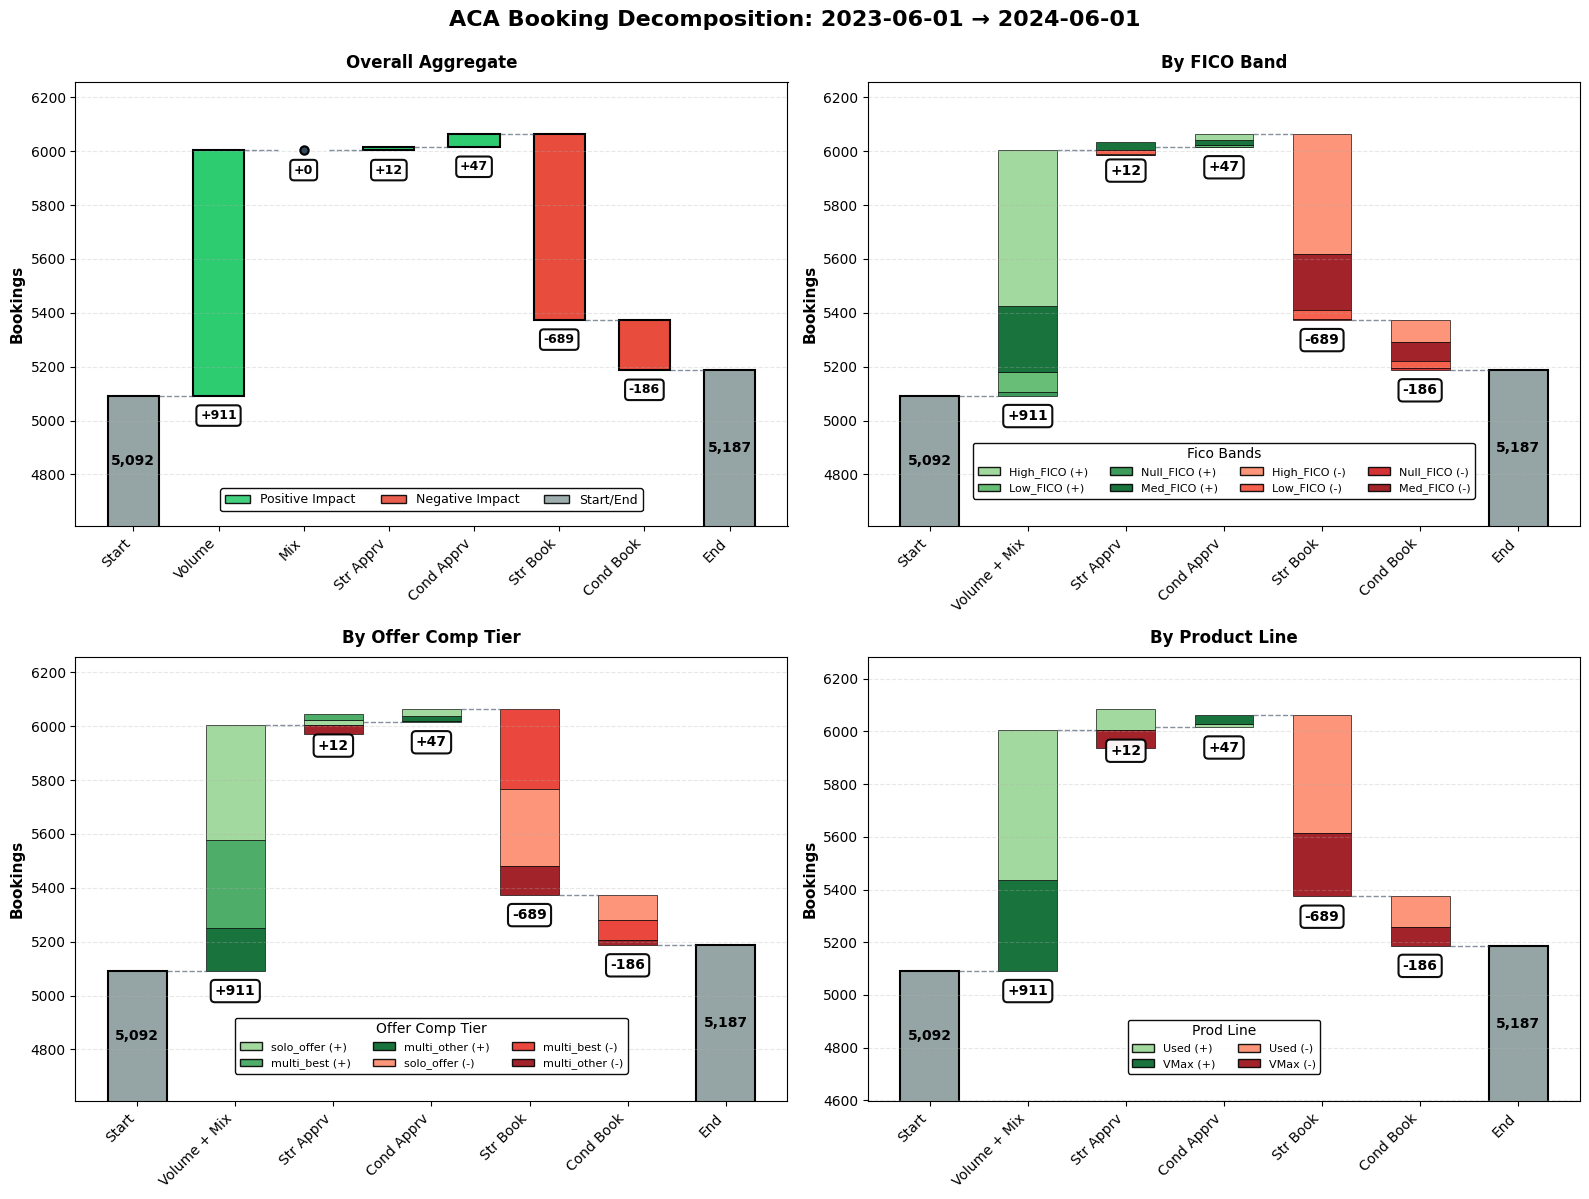

In [5]:
# Create waterfall grid
fig = visualization_engine.create_waterfall_grid(
    summary=results.summary,
    segment_detail=results.segment_detail,
    lender='ACA'
)

plt.show()

## 5. Detailed Breakdowns by Dimension

For each dimensional waterfall, we can view the exact contribution of each dimension value:

In [6]:
# Print detailed breakdowns
visualization_engine.print_waterfall_breakdowns(fig)


BREAKDOWN BY FICO BANDS

 effect_type total_impact positive_contrib negative_contrib Null_FICO_positive Low_FICO_positive Med_FICO_positive High_FICO_positive Low_FICO_negative High_FICO_negative Null_FICO_negative Med_FICO_negative
Volume + Mix        911.3            911.3              0.0               13.1              75.4             243.3              579.6                 -                  -                  -                 -
   Str Apprv         12.3             31.5            -19.2                  -                 -              31.5                  -             -14.8               -3.9               -0.5                 -
  Cond Apprv         47.3             47.3              0.0                0.3               8.1              18.5               20.4                 -                  -                  -                 -
    Str Book       -688.9              0.0           -688.9                  -                 -                 -                  -         

## 6. Dimension Drilldown Charts

We can create horizontal bar charts showing the impact of each effect broken down by a specific dimension.

### By FICO Band

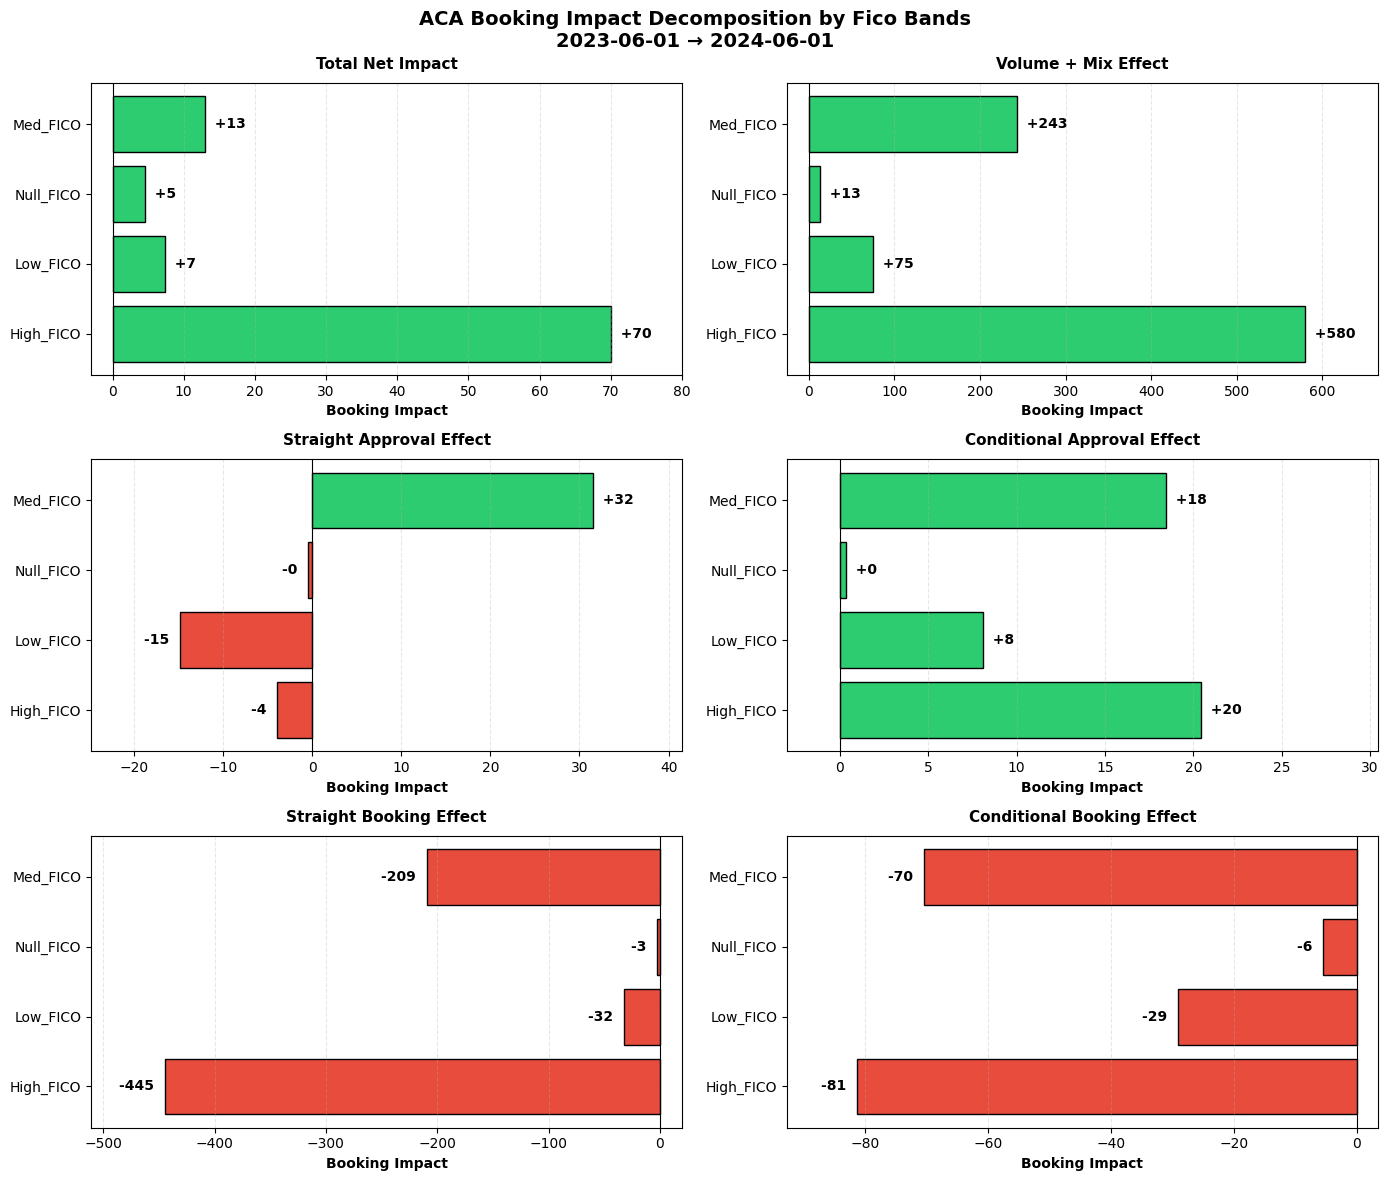

In [7]:
# Create FICO band drilldown
fig_fico = visualization_engine.create_dimension_drilldown(
    segment_detail=results.segment_detail,
    dimension='fico_bands',
    lender='ACA'
)

plt.show()

### By Offer Comp Tier

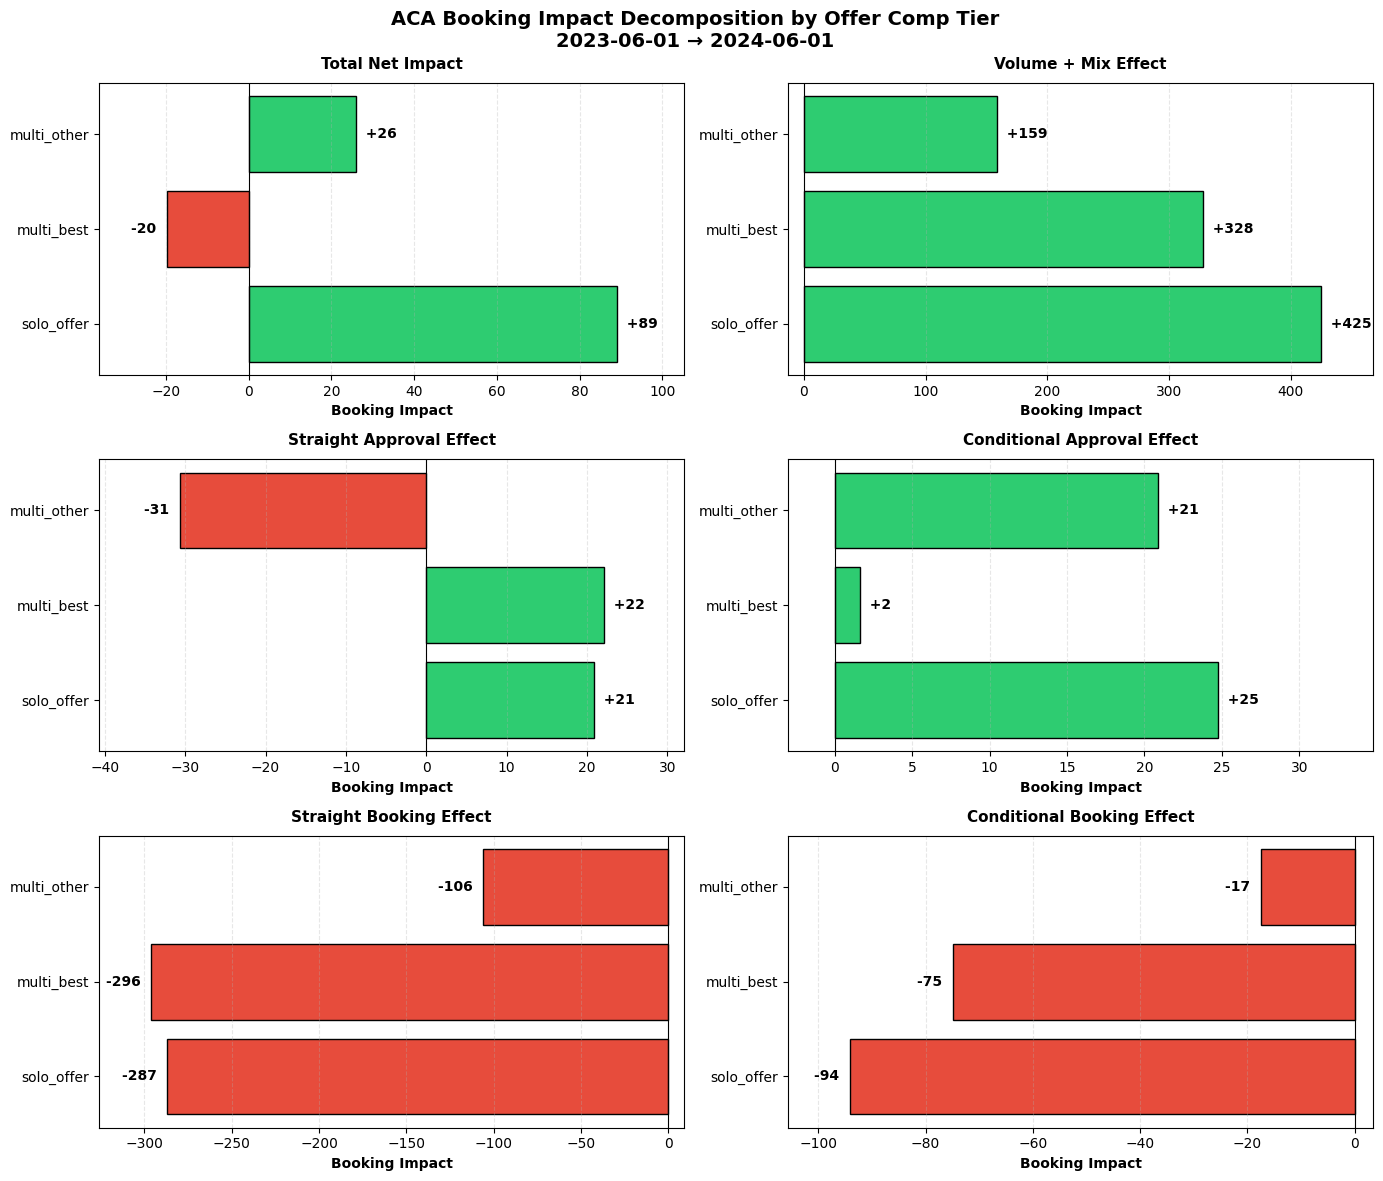

In [8]:
# Create Offer Comp Tier drilldown
fig_comp = visualization_engine.create_dimension_drilldown(
    segment_detail=results.segment_detail,
    dimension='offer_comp_tier',
    lender='ACA'
)

plt.show()

### By Product Line

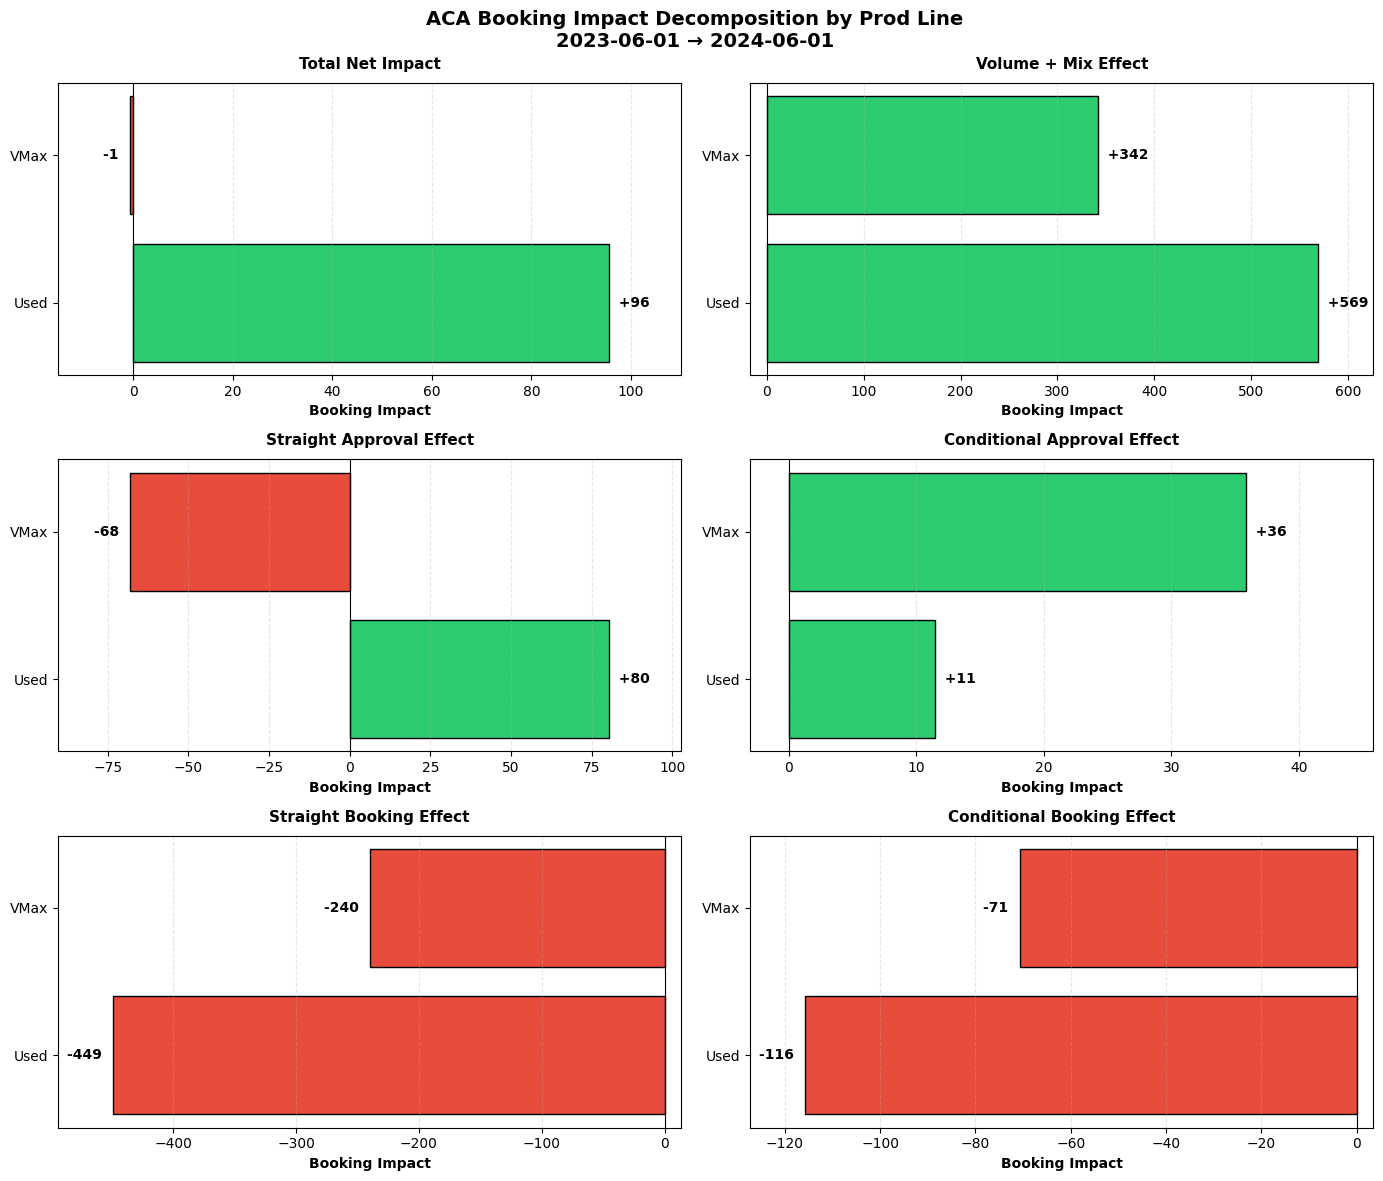

In [9]:
# Create Product Line drilldown
fig_prod = visualization_engine.create_dimension_drilldown(
    segment_detail=results.segment_detail,
    dimension='prod_line',
    lender='ACA'
)

plt.show()

## 7. Segment-Level Detail

For detailed analysis, we can examine the segment-level breakdown:

In [10]:
# Show segment detail (first 10 segments)
results.segment_detail.head(10)

,fico_bands,offer_comp_tier,prod_line,period_1_date,period_1_total_apps,period_1_pct_of_total,period_1_segment_apps,period_1_str_apprv_rate,period_1_str_bk_rate,period_1_cond_apprv_rate,...,delta_cond_bk_rate,delta_segment_bookings,volume_effect,mix_effect,str_approval_effect,cond_approval_effect,str_booking_effect,cond_booking_effect,interaction_effect,total_effect
0,High_FICO,multi_best,Used,2023-06-01,14573,0.119658,1743.777778,0.505422,0.644748,0.244578,...,-0.031075,46.227733,129.232883,0.0,15.245495,15.090364,-97.870665,-15.290826,-0.179519,46.227733
1,High_FICO,multi_best,VMax,2023-06-01,14573,0.076923,1121.000000,0.556486,0.714620,0.225156,...,-0.089180,-75.897320,87.702572,0.0,-34.683095,4.685214,-108.544817,-25.393638,0.336446,-75.897320
2,High_FICO,multi_other,Used,2023-06-01,14573,0.064103,934.166667,0.476437,0.681085,0.223563,...,0.004178,-8.726671,63.092863,0.0,-12.546784,5.669966,-66.070742,0.999511,0.128515,-8.726671
3,High_FICO,multi_other,VMax,2023-06-01,14573,0.038462,560.500000,0.466906,0.639702,0.233094,...,-0.056623,26.223321,39.208103,0.0,-0.717696,5.302792,-8.894696,-8.631041,-0.044140,26.223321
4,High_FICO,solo_offer,Used,2023-06-01,14573,0.145299,2117.444444,0.481621,0.649635,0.262995,...,-0.020158,79.113264,155.452518,0.0,76.958463,-27.260855,-114.165308,-11.407162,-0.464392,79.113264
5,High_FICO,solo_offer,VMax,2023-06-01,14573,0.094017,1370.111111,0.512601,0.678012,0.228853,...,-0.058590,3.069680,104.907456,0.0,-48.193022,16.951735,-49.063838,-21.622767,0.090116,3.069680
6,Low_FICO,multi_best,Used,2023-06-01,14573,0.031624,460.855556,0.296911,0.392057,0.403089,...,-0.042148,4.708794,15.865071,0.0,-4.485950,1.818622,0.358979,-8.825529,-0.022398,4.708794
7,Low_FICO,multi_best,VMax,2023-06-01,14573,0.015385,224.200000,0.350448,0.420926,0.349552,...,0.011432,0.068258,8.599455,0.0,-7.252364,3.976632,-6.427465,1.091711,0.080289,0.068258
8,Low_FICO,multi_other,Used,2023-06-01,14573,0.015385,224.200000,0.278216,0.428851,0.421784,...,0.045511,8.766217,8.278487,0.0,-2.843718,1.349909,-2.924569,4.878219,0.027890,8.766217
9,Low_FICO,multi_other,VMax,2023-06-01,14573,0.007692,112.100000,0.249711,0.466565,0.450289,...,-0.076668,-1.377308,4.373442,0.0,0.629128,-0.294144,-1.898676,-4.188088,0.001029,-1.377308


## 8. Compare Symmetric vs Hierarchical (Optional)

To understand the difference between symmetric and hierarchical decomposition, you can run both and compare:

```python
import hier_decomposition_calculator

# Calculate hierarchical decomposition
results_hier = hier_decomposition_calculator.calculate_decomposition(
    df=df,
    date_a='2023-06-01',
    date_b='2024-06-01',
    lender='ACA'
)

# Compare summaries
comparison = pd.merge(
    results.summary,
    results_hier.summary,
    on='effect_type',
    suffixes=('_symmetric', '_hierarchical')
)
comparison['difference'] = comparison['booking_impact_symmetric'] - comparison['booking_impact_hierarchical']
comparison
```

## 9. Export Results (Optional)

Results can be exported using pandas if needed:

In [11]:
# Export functionality
# results.summary.to_csv('symmetric_summary.csv', index=False)
# results.segment_detail.to_csv('symmetric_segment_detail.csv', index=False)

## Summary

The **symmetric decomposition** provides an order-independent analysis of booking changes by:

1. Using average values from both periods for all calculations
2. Calculating all effects independently (no sequential dependencies)
3. Ensuring the decomposition results don't depend on the order of effects

This approach is particularly useful when:
- You want a balanced view that doesn't favor one period over another
- Order independence is important for your analysis
- You're comparing multiple decompositions and want consistent methodology

The hierarchical approach may still be preferred when:
- You want to see the incremental impact of each change
- Sequential logic matches your business decision-making process
- You're explaining a specific step-by-step transformation